In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import zscore, linregress
from pandas.plotting import scatter_matrix
from scipy import stats
import numpy as np

In [3]:
# Function to remove outliers from a dataframe
from sklearn.neighbors import LocalOutlierFactor


def remove_outliers(df):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Fit the LocalOutlierFactor model to the column data
        lof = LocalOutlierFactor()
        outliers = lof.fit_predict(df[col].values.reshape(-1, 1))

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers == -1)

    # Drop rows with outliers
    # cleaned_df = df[~outlier_rows_mask]
    return outlier_rows_mask

In [4]:
fluxnet_info = pd.read_csv("../data/EC/fluxnet/sites_info.csv")
ameriflux_info = pd.read_csv("../data/EC/Ameriflux/sites_info.tsv", delimiter="\t")

In [5]:
fluxnet_names = fluxnet_info["ID"].to_list()
fluxnet_types = fluxnet_info["type"].to_list()
ameriflux_names = ameriflux_info["Site ID"].to_list()
ameriflux_types = ameriflux_info["Vegetation Abbreviation (IGBP)"].to_list()

In [6]:
combined_names = list(set(ameriflux_names + fluxnet_names))
combined_types = []
for name in combined_names:
    if name in ameriflux_names and name in fluxnet_names:
        # Choose a type from either fluxnet_types or ameriflux_types
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])
    elif name in ameriflux_names:
        combined_types.append(ameriflux_types[ameriflux_names.index(name)])
    else:
        combined_types.append(fluxnet_types[fluxnet_names.index(name)])

In [7]:
dfs = []

# Iterate over the range of length of 'name' column in sites_info
for i in range(len(combined_names)):
    site_name = combined_names[i]
    site_type = combined_types[i]

    # Set the file path based on whether the combined name is in ameriflux_names or fluxnet_names
    if site_name in ameriflux_names:
        file = glob.glob("../data/EC/Ameriflux/AMF_" + site_name + "*WW*")
    else:
        file = glob.glob("../data/EC/fluxnet/FLX_" + site_name + "*WW*")

    # Open the CSV file
    ec = pd.read_csv(file[0])
    ec.loc[:, "type"] = site_type
    ec.loc[:, "name"] = site_name

    ec["t1"] = pd.to_datetime(ec["TIMESTAMP_START"], format="%Y%m%d")
    ec["t2"] = pd.to_datetime(ec["TIMESTAMP_END"], format="%Y%m%d")

    # Append the DataFrame to the list
    dfs.append(ec)

# Concatenate all DataFrames in the list
combined_ec = pd.concat(dfs)

In [8]:
MCD43_fluxnet = []
MCD15_fluxnet = []
MCD43_ameriflux = []
MCD15_ameriflux = []

# Loop over batches (#5) of downloaded data
for i in range(1, 5):
    refl_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
    )
    sat_refl_fluxnet = pd.read_csv(refl_fluxnet[0])
    sat_refl_fluxnet.loc[:, "time"] = pd.to_datetime(sat_refl_fluxnet["Date"])
    sat_refl_fluxnet.set_index(sat_refl_fluxnet["Date"], inplace=True)
    MCD43_fluxnet.append(sat_refl_fluxnet)

    fpar_fluxnet = glob.glob(
        "../data/EC/fluxnet/sat_data/*batch" + str(i) + "*MCD15A3H-061-results.csv"
    )
    sat_fpar_fluxnet = pd.read_csv(fpar_fluxnet[0])
    sat_fpar_fluxnet.loc[:, "time"] = pd.to_datetime(sat_fpar_fluxnet["Date"])
    sat_fpar_fluxnet.set_index(sat_fpar_fluxnet["Date"], inplace=True)
    MCD15_fluxnet.append(sat_fpar_fluxnet)

    if i < 5:
        refl_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch" + str(i) + "*MCD43A4-061-results.csv"
        )

        sat_refl_ameriflux = pd.read_csv(refl_ameriflux[0])
        sat_refl_ameriflux.loc[:, "time"] = pd.to_datetime(sat_refl_ameriflux["Date"])
        sat_refl_ameriflux.set_index(sat_refl_ameriflux["Date"], inplace=True)
        MCD43_ameriflux.append(sat_refl_ameriflux)

        fpar_ameriflux = glob.glob(
            "../data/EC/Ameriflux/sat_data/*batch"
            + str(i)
            + "*MCD15A3H-061-results.csv"
        )
        fpar_ameriflux = pd.read_csv(fpar_ameriflux[0])

        fpar_ameriflux.loc[:, "time"] = pd.to_datetime(fpar_ameriflux["Date"])
        fpar_ameriflux.set_index(fpar_ameriflux["Date"], inplace=True)
        MCD15_ameriflux.append(fpar_ameriflux)


refl_fluxnet = pd.concat(MCD43_fluxnet)
refl_fluxnet = refl_fluxnet.rename(columns={"ID": "name"})

fpar_fluxnet = pd.concat(MCD15_fluxnet)
fpar_fluxnet = fpar_fluxnet.rename(columns={"ID": "name"})

refl_ameriflux = pd.concat(MCD43_ameriflux)
refl_ameriflux = refl_ameriflux.rename(columns={"ID": "name"})
fpar_ameriflux = pd.concat(MCD15_ameriflux)
fpar_ameriflux = fpar_ameriflux.rename(columns={"ID": "name"})
combined_refl = []
combined_fpar = []

for name in combined_names:
    if name in ameriflux_names:
        selected_refl = refl_ameriflux[refl_ameriflux["name"] == name]
        selected_fpar = fpar_ameriflux[fpar_ameriflux["name"] == name]
    else:
        selected_refl = refl_fluxnet[refl_fluxnet["name"] == name]
        selected_fpar = fpar_fluxnet[fpar_fluxnet["name"] == name]

    combined_refl.append(selected_refl)
    combined_fpar.append(selected_fpar)

combined_refl = pd.concat(combined_refl)
combined_fpar = pd.concat(combined_fpar)

In [20]:
bad_sites_list = []
i = combined_names.index("US-Ha1")
site_name = combined_names[i]
site_type = combined_types[i]
site_ec = combined_ec[combined_ec["name"] == site_name]
site_refl = combined_refl[combined_refl["name"] == site_name]
site_fpar = combined_fpar[combined_fpar["name"] == site_name]
if site_ec["PPFD_IN_QC"].isna().all():
    print("No PPFD data for " + site_name)
    bad_sites_list.append(site_name)
gpp = site_ec[["GPP_NT_VUT_REF"]]
par = site_ec[["PPFD_IN"]]
par_qc = site_ec[["PPFD_IN_QC"]]
t1 = site_ec[["t1"]]
t2 = site_ec[["t2"]]
ec_weekly = pd.concat([t1, t2, gpp, par, par_qc], axis=1).rename(
    columns={"GPP_NT_VUT_REF": "gpp", "PPFD_IN": "par", "PPFD_IN_QC": "par_qc"}
)
ec_weekly = ec_weekly[ec_weekly["par_qc"] == 1]
ec_weekly = ec_weekly[ec_weekly["gpp"] != -9999]
ec_weekly.drop(columns=["par_qc"], inplace=True)
ec_weekly

,t1,t2,gpp,par
43,1991-10-29,1991-11-04,1.129360,154.986111
44,1991-11-05,1991-11-11,0.690604,155.993056
45,1991-11-12,1991-11-18,0.397190,126.958333
46,1991-11-19,1991-11-25,0.333499,90.020833
47,1991-11-26,1991-12-02,0.325818,113.006944
...,...,...,...,...
1555,2020-11-25,2020-12-01,0.405745,90.004861
1556,2020-12-02,2020-12-08,-0.113861,127.948611
1557,2020-12-09,2020-12-15,-0.147078,86.708333
1558,2020-12-16,2020-12-22,-0.300978,108.763194


In [21]:
site_fpar_filtered = site_fpar[
    (site_fpar["MCD15A3H_061_FparLai_QC_MODLAND"] == "0b0")
    & (site_fpar["MCD15A3H_061_FparLai_QC_DeadDetector"] == "0b0")
    & (site_fpar["MCD15A3H_061_FparLai_QC_CloudState"] == "0b00")
    & (site_fpar["MCD15A3H_061_FparLai_QC_SCF_QC"].isin(["0b000", "0b001"]))
]
site_fpar_filtered.index = pd.to_datetime(site_fpar_filtered.index)

In [22]:
site_refl_filtered = site_refl[
    (
        site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band1_MODLAND"]
        == "0b000"
    )
    & (
        site_refl["MCD43A4_061_BRDF_Albedo_Band_Mandatory_Quality_Band2_MODLAND"]
        == "0b000"
    )
]

site_refl_filtered.index = pd.to_datetime(site_refl_filtered.index)

In [23]:
resampled_fpar = []
resampled_refl = []

for idx, row in ec_weekly.iterrows():
    # Select the data for the current week
    t1 = pd.to_datetime(row["t1"])
    t2 = pd.to_datetime(row["t2"])
    mask_fpar = (site_fpar_filtered.index >= t1) & (site_fpar_filtered.index <= t2)
    weekly_data_fpar = site_fpar_filtered[mask_fpar]

    mask_refl = (site_refl_filtered.index >= t1) & (site_refl_filtered.index <= t2)
    weekly_data_refl = site_refl_filtered[mask_refl]

    if (weekly_data_fpar.empty) | (weekly_data_refl.empty):
        continue

    red_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band1"].mean()
    nir_tmp = weekly_data_refl["MCD43A4_061_Nadir_Reflectance_Band2"].mean()

    tmp_fpar = weekly_data_fpar["MCD15A3H_061_Fpar_500m"]
    tmp_fpar_mean = tmp_fpar.mean()
    resampled_fpar.append({"t1": t1, "t2": t2, "fpar_mean": tmp_fpar_mean})
    resampled_refl.append({"t1": t1, "t2": t2, "red": red_tmp, "nir": nir_tmp})

resampled_fpar_df = pd.DataFrame(resampled_fpar)
resampled_refl_df = pd.DataFrame(resampled_refl)
# Select rows from site_ec where t1 and t2 match those in resampled_fpar_df and resampled_refl_df
mask = (
    ec_weekly["t1"].isin(resampled_fpar_df["t1"])
    & ec_weekly["t2"].isin(resampled_fpar_df["t2"])
) | (
    ec_weekly["t1"].isin(resampled_refl_df["t1"])
    & ec_weekly["t2"].isin(resampled_refl_df["t2"])
)

resampled_ec_df = ec_weekly[mask]  # Note: although called resampled, we dont resample,

In [24]:
# First merge resampled_fpar_df and resampled_refl_df
merged_df = pd.merge(resampled_fpar_df, resampled_refl_df, how="inner", on=["t1", "t2"])

# Then merge the result with resampled_ec_df
site_df = pd.merge(merged_df, resampled_ec_df, how="inner", on=["t1", "t2"]).copy()
site_df.loc[:, "ndvi"] = (site_df["nir"] - site_df["red"]) / (
    site_df["nir"] + site_df["red"]
)
site_df.loc[:, "nirv"] = site_df["ndvi"] * site_df["nir"]
site_df.loc[:, "nirvp"] = site_df["nirv"] * site_df["par"]
site_df.loc[:, "fesc"] = site_df["nirv"] / site_df["fpar_mean"]
site_df.loc[:, "lue"] = site_df["gpp"] / (site_df["par"] * site_df["fpar_mean"])

In [25]:
def remove_outliers(df):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Fit the LocalOutlierFactor model to the column data
        lof = LocalOutlierFactor()
        outliers = lof.fit_predict(df[col].values.reshape(-1, 1))

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers == -1)

    # Drop rows with outliers
    cleaned_df = df[~outlier_rows_mask]
    return cleaned_df


# Remove outliers in each column of site_df
cleaned_site_df = remove_outliers(site_df)

In [26]:
cleaned_site_df

,t1,t2,fpar_mean,red,nir,gpp,par,ndvi,nirv,nirvp,fesc,lue
0,2002-07-09,2002-07-15,0.930,0.020171,0.403700,12.605400,580.981944,0.904823,0.365277,212.219342,0.392771,0.023330
2,2002-07-23,2002-07-29,0.930,0.022650,0.370150,12.312400,389.638889,0.884674,0.327462,127.591981,0.352110,0.033978
3,2002-08-06,2002-08-12,0.920,0.019671,0.379829,12.618800,537.953472,0.901520,0.342423,184.207621,0.372199,0.025497
5,2002-08-27,2002-09-02,0.900,0.021633,0.356100,8.209350,321.722917,0.885457,0.315311,101.442864,0.350346,0.028352
6,2002-09-03,2002-09-09,0.920,0.021443,0.344600,10.238900,430.807639,0.882840,0.304227,131.063117,0.330681,0.025833
...,...,...,...,...,...,...,...,...,...,...,...,...
578,2020-09-30,2020-10-06,0.400,0.035617,0.279633,1.472930,319.081944,0.774042,0.216448,69.064610,0.541120,0.011540
579,2020-10-07,2020-10-13,0.750,0.040214,0.261386,1.510180,328.615278,0.733327,0.191681,62.989373,0.255575,0.006127
580,2020-10-14,2020-10-20,0.510,0.041029,0.244914,1.145600,275.317361,0.713030,0.174631,48.078982,0.342414,0.008159
581,2020-11-04,2020-11-10,0.550,0.040829,0.181086,0.801713,258.269444,0.632033,0.114452,29.559491,0.208095,0.005644


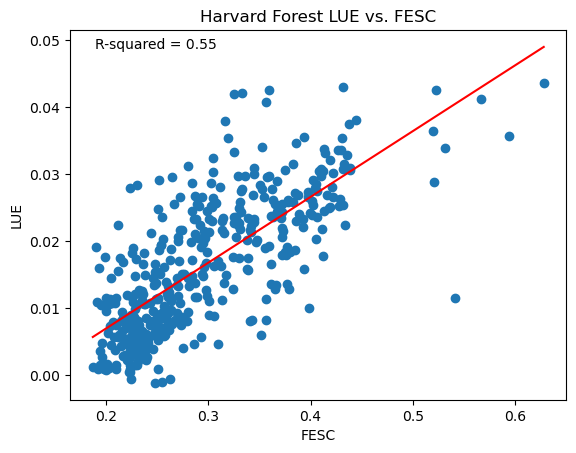

In [29]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

plt.scatter(cleaned_site_df["fesc"], cleaned_site_df["lue"])
plt.xlabel("FESC")
plt.ylabel("LUE")
plt.title("Harvard Forest LUE vs. FESC")

# Calculate the linear regression and R-squared value
slope, intercept, r_value, p_value, std_err = linregress(
    cleaned_site_df["fesc"], cleaned_site_df["lue"]
)
r_squared = r_value**2

# Annotate the R-squared value on the plot
plt.annotate(f"R-squared = {r_squared:.2f}", xy=(0.05, 0.95), xycoords="axes fraction")

# Generate x values for the linear line
x_fit = np.linspace(cleaned_site_df["fesc"].min(), cleaned_site_df["fesc"].max(), 1000)

# Compute the y values of the linear line
y_fit = slope * x_fit + intercept

# Plot the linear line
plt.plot(x_fit, y_fit, "r-")

plt.savefig("../outputs/figures/weekly_harvard_scatter.png")